In [1]:
# (in the case of target axis AB) 
# Calculate only the A evidence for A (input A for classifier AC and AD) compared 
# with A evidence for B (input B for classifier AC and AD) ; 
# B evidence for B (input B for classifier BC and BD) compared with B 
# evidence for A (input A for classifier BC and BD)


import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import joblib
import nibabel as nib
import itertools
from sklearn.linear_model import LogisticRegression
from IPython.display import clear_output
import sys
from subprocess import call
import pickle
import pdb
import time
from tqdm import tqdm
from scipy import stats

def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

def normalize(X):
    X = X - X.mean(0)
    return X

def jitter(size,const=0):
    jit = np.random.normal(0+const, 0.05, size)
    X = np.zeros((size))
    X = X + jit
    return X

def other(target):
    other_objs = [i for i in ['bed', 'bench', 'chair', 'table'] if i not in target]
    return other_objs

def red_vox(n_vox, prop=0.1):
    return int(np.ceil(n_vox * prop))

def logit(p):
    return 1/(1+np.exp(-p))

def classifierEvidence(clf,X,Y): # X shape is [trials,voxelNumber], Y is ['bed', 'bed'] for example # return a 1-d array of probability
    # This function get the data X and evidence object I want to know Y, and output the trained model evidence.
    targetID=[np.where((clf.classes_==i)==True)[0][0] for i in Y]
    Evidence1=[clf.predict_proba(X[i,:].reshape(1,-1))[0][j] for i,j in enumerate(targetID)] # logit(X*clf.coef_+clf.intercept_)
    Evidence2=[(np.sum(X[i,:]*clf.coef_)+clf.intercept_) if j==1 else (1-(np.sum(X[i,:]*clf.coef_)+clf.intercept_)) for i,j in enumerate(targetID)] # X*clf.coef_+clf.intercept_ # np.sum((X*clf.coef_+clf.intercept_), axis=1) #logit(np.sum((X*clf.coef_[0]+clf.intercept_),axis=1)) is very close to clf.predict_proba(X), but not exactly equal
    Evidence=(np.sum(X*clf.coef_,axis=1)+clf.intercept_) if targetID[0]==1 else (1-(np.sum(X*clf.coef_,axis=1)+clf.intercept_))
    pdb.set_trace()
    return np.asarray(Evidence)

def saveNpInDf(array):
    dataDir='./saveNpInDf/'
    if not os.path.isdir(dataDir):
        os.mkdir(dataDir)
    fileName=dataDir+str(time.time())
    np.save(fileName,array)
    return fileName

def get_inds(X, Y, pair, testRun=None):
    
    inds = {}
    
    # return relative indices
    if testRun:
        trainIX = Y.index[(Y['label'].isin(pair)) & (Y['run_num'] != int(testRun))]
    else:
        trainIX = Y.index[(Y['label'].isin(pair))]

    # pull training and test data
    trainX = X[trainIX]
    trainY = Y.iloc[trainIX].label
    
    # Main classifier on 5 runs, testing on 6th
    clf = LogisticRegression(penalty='l2',C=1, solver='lbfgs', max_iter=1000, 
                            multi_class='multinomial').fit(trainX, trainY)
    B = clf.coef_[0]  # pull betas

    # retrieve only the first object, then only the second object
    if testRun:
        obj1IX = Y.index[(Y['label'] == pair[0]) & (Y['run_num'] != int(testRun))]
        obj2IX = Y.index[(Y['label'] == pair[1]) & (Y['run_num'] != int(testRun))]
    else:
        obj1IX = Y.index[(Y['label'] == pair[0])]
        obj2IX = Y.index[(Y['label'] == pair[1])]
    # Get the average of the first object, then the second object
    obj1X = np.mean(X[obj1IX], 0)
    obj2X = np.mean(X[obj2IX], 0)

    # Build the importance map
    mult1X = obj1X * B
    mult2X = obj2X * B

    # Sort these so that they are from least to most important for a given category.
    sortmult1X = mult1X.argsort()[::-1]
    sortmult2X = mult2X.argsort()

    # add to a dictionary for later use
    inds[clf.classes_[0]] = sortmult1X
    inds[clf.classes_[1]] = sortmult2X
            
    return inds

def getEvidence(sub,testEvidence,METADICT=None,FEATDICT=None,filterType=None,roi="V1",include=1,testRun=6,model_folder=None):
    # each testRun, each subject, each target axis, each target obj would generate one.
    META = METADICT[sub]
    print('META.shape=',META.shape)
    FEAT = FEATDICT[sub]
    # Using the trained model, get the evidence
    
    objects=['bed', 'bench', 'chair', 'table']

    allpairs = itertools.combinations(objects,2)
    for pair in allpairs: # e.g. pair=('bed', 'bench')
        # Find the control (remaining) objects for this pair
        altpair = other(pair) #altpair=('chair', 'table')

        # obj is A
        # otherObj is B
        # altpair[0] is C
        # altpair[1] is D

        for obj in pair: # obj='bed', obj is A
            # in the current target axis pair=('bed', 'bench') altpair=('chair', 'table'), display image obj='bed'
            # find the evidence for bed from the (bed chair) and (bed table) classifier

            # get the test data and seperate the test data into category obj and category other
            otherObj=[i for i in pair if i!=obj][0] # otherObj is B
            print('otherObj=',otherObj) # This is B
            objID = META.index[(META['label'].isin([obj])) & (META['run_num'] == int(testRun))]
            otherObjID = META.index[(META['label'].isin([otherObj])) & (META['run_num'] == int(testRun))]
            
            obj_X=FEAT[objID] # A features
            otherObj_X=FEAT[otherObjID] # B features

            print(f'loading {model_folder}{sub}_{pair[0]}{pair[1]}_{obj}{altpair[0]}.joblib')
            print(f'loading {model_folder}{sub}_{pair[0]}{pair[1]}_{obj}{altpair[1]}.joblib')
            AC_clf = joblib.load(f'{model_folder}{sub}_{pair[0]}{pair[1]}_{obj}{altpair[0]}.joblib') # AC classifier
            AD_clf = joblib.load(f'{model_folder}{sub}_{pair[0]}{pair[1]}_{obj}{altpair[1]}.joblib') # AD classifier

            if include < 1:
                # This is selected features by importance
                selectedFeatures=load_obj(f'{model_folder}{sub}_{pair[0]}{pair[1]}_{obj}{altpair[0]}.selectedFeatures') # AC classifier
                obj_X=obj_X[:,selectedFeatures]
                selectedFeatures=load_obj(f'{model_folder}{sub}_{pair[0]}{pair[1]}_{obj}{altpair[1]}.selectedFeatures') # AD classifier
                otherObj_X=otherObj_X[:,selectedFeatures]

            AC_A_evidence = classifierEvidence(AC_clf,obj_X,[obj] * obj_X.shape[0]) # AC classifier A evidence for A trials
            AD_A_evidence = classifierEvidence(AD_clf,obj_X,[obj] * obj_X.shape[0]) # AD classifier A evidence for A trials
            A_evidence_forATrials = np.mean([AC_A_evidence, AD_A_evidence],axis=0) # AC and AD classifier A evidence for A trials ; shape=(20,)

            AC_B_evidence = classifierEvidence(AC_clf,otherObj_X,[obj] * otherObj_X.shape[0]) # AC classifier A evidence for B trials
            AD_B_evidence = classifierEvidence(AD_clf,otherObj_X,[obj] * otherObj_X.shape[0]) # AD classifier A evidence for B trials
            A_evidence_forBTrials = np.mean([AC_B_evidence, AD_B_evidence],axis=0) # AC and AD classifier A evidence for B trials ; shape=(20,)
            
            # save the evidenced to testEvidence df
            testEvidence = testEvidence.append({
                'sub':sub,
                'testRun':testRun,
                'targetAxis':pair,
                'obj':obj,
                'otherObj':otherObj,
                
                'AC_A_evidence':saveNpInDf(AC_A_evidence), # AC classifier A evidence for A
                'AD_A_evidence':saveNpInDf(AD_A_evidence), # AD classifier A evidence for A
                'AC_B_evidence':saveNpInDf(AC_B_evidence), # AC classifier A evidence for B
                'AD_B_evidence':saveNpInDf(AD_B_evidence), # AD classifier A evidence for B

                'A_evidence_forATrials':saveNpInDf(A_evidence_forATrials),
                'A_evidence_forBTrials':saveNpInDf(A_evidence_forBTrials),
                'A_evidence_forBTrials_minus_A_evidence_forBTrials':np.mean(A_evidence_forATrials) - np.mean(A_evidence_forBTrials),

                'filterType':filterType,
                'include':include,
                'roi':roi
                },
                ignore_index=True)

    return testEvidence

def minimalClass(filterType = 'noFilter',testRun = 6, roi="V1",include = 1,model_folder=None,tag=''): #include is the proportion of features selected
    
    accuracyContainer = pd.DataFrame(columns=['sub','testRun','targetAxis','obj','altobj','acc','filterType','roi'])
    testEvidence = pd.DataFrame(columns=['sub','testRun','targetAxis','obj','obj_evidence','otherObj_evidence','filterType','roi'])

    # working_dir='/gpfs/milgram/project/turk-browne/projects/rtcloud_kp/FilterTesting/neurosketch_realtime_preprocess/'
    # os.chdir(working_dir)

    # data_dir=f'/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/features/{filterType}/recognition/'
    if filterType=='KalmanFilter_filter_analyze_voxel_by_voxel':
        data_dir=f'/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/features/{filterType}/recognition/{tag}/' # condition1: filter everything (including the first 56s) train and filter the Kalman at the same time.
    else:
        data_dir=f'/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/features/{filterType}/recognition/'

    

    files = os.listdir(data_dir)
    feats = [i for i in files if 'metadata' not in i]
    subjects = np.unique([i.split('_')[0] for i in feats if i.split('_')[0] not in ['1121161','0112174']]) # 1121161 has a grid spacing issue and 0112174 lacks one of regressor file
    # If you want to reduce the number of subjects used for testing purposes
    subs=len(subjects) # subs=1
    subjects = subjects[:subs]
    subjects=['0110171','1206161']
    print('subjects=',subjects)

    objects = ['bed', 'bench', 'chair', 'table']
    phases = ['12', '34', '56']

    # THIS CELL READS IN ALL OF THE PARTICIPANTS' DATA and fills into dictionary
    FEATDICT = {}
    METADICT = {}
    subjects_new=[]
    for si, sub in enumerate(subjects[:]):
        try:
            print('{}/{}'.format(si+1, len(subjects)))
            for phase in phases:
                _feat = np.load(data_dir+'/{}_{}_{}_featurematrix.npy'.format(sub, roi, phase))
                _feat = normalize(_feat)
                _meta = pd.read_csv(data_dir+'/metadata_{}_{}_{}.csv'.format(sub, roi, phase))
                if phase!='12':
                    assert _feat.shape[1]==FEAT.shape[1], 'feat shape not matched'
                FEAT = _feat if phase == "12" else np.vstack((FEAT, _feat))
                META = _meta if phase == "12" else pd.concat((META, _meta))
            META = META.reset_index(drop=True)

            assert FEAT.shape[0] == META.shape[0]

            METADICT[sub] = META
            FEATDICT[sub] = FEAT
            clear_output(wait=True)
            subjects_new.append(sub)
        except:
            pass


    # Which run to use as test data (leave as None to not have test data)
    subjects=subjects_new

    # train the models; Decide on the proportion of crescent data to use for classification
    for si,sub in enumerate(subjects):
        # try:
        print('{}/{}'.format(si+1, len(subjects)))
        print(sub)
        META = METADICT[sub]
        FEAT = FEATDICT[sub]
        allpairs = itertools.combinations(objects,2)
        # Iterate over all the possible target pairs of objects
        for pair in allpairs:
            # Find the control (remaining) objects for this pair
            altpair = other(pair)
            
            # pull sorted indices for each of the critical objects, in order of importance (low to high)
            inds = get_inds(FEAT, META, pair, testRun=testRun)
            
            # Find the number of voxels that will be left given your inclusion parameter above
            nvox = red_vox(FEAT.shape[1], include)

            for obj in pair:
                # foil = [i for i in pair if i != obj][0]
                for altobj in altpair:
                    # establish a naming convention where it is $TARGET_$CLASSIFICATION
                    # Target is the NF pair (e.g. bed/bench)
                    # Classificationis is btw one of the targets, and a control (e.g. bed/chair, or bed/table, NOT bed/bench)
                    naming = '{}{}_{}{}'.format(pair[0], pair[1], obj, altobj)
                    
                    # Pull the relevant inds from your previously established dictionary 
                    obj_inds = inds[obj]
                    
                    # If you're using testdata, this function will split it up. Otherwise it leaves out run as a parameter
                    if testRun:
                        trainIX = META.index[(META['label'].isin([obj, altobj])) & (META['run_num'] != int(testRun))]
                        testIX = META.index[(META['label'].isin([obj, altobj])) & (META['run_num'] == int(testRun))]
                    else:
                        trainIX = META.index[(META['label'].isin([obj, altobj]))]
                        testIX = META.index[(META['label'].isin([obj, altobj]))]

                    # pull training and test data
                    trainX = FEAT[trainIX]
                    testX = FEAT[testIX]
                    trainY = META.iloc[trainIX].label
                    testY = META.iloc[testIX].label
                    
                    # If you're selecting high-importance features, this bit handles that
                    if include < 1:
                        trainX = trainX[:, obj_inds[-nvox:]]
                        testX = testX[:, obj_inds[-nvox:]]
                    
                    # Train your classifier
                    model_path=model_folder + '{}_{}.joblib'.format(sub, naming)
                    if os.path.exists(model_path):
                       clf=joblib.load(model_path)
                    else:
                        clf = LogisticRegression(penalty='l2',C=1, solver='lbfgs', max_iter=1000, 
                                                multi_class='multinomial').fit(trainX, trainY)
                        joblib.dump(clf, model_path)
                        save_obj(obj_inds[-nvox:],f'{model_folder}{sub}_{naming}.selectedFeatures')

                    # Monitor progress by printing accuracy (only useful if you're running a test set)
                    acc = clf.score(testX, testY)
                    if (si+1)%10==0:
                        print(naming, acc)
                    accuracyContainer = accuracyContainer.append({
                        'sub':sub,
                        'testRun':testRun,
                        'targetAxis':pair,
                        'obj':obj,
                        'altobj':altobj,
                        'acc':acc,
                        'filterType':filterType,
                        'include':include,
                        'roi':roi
                        },
                        ignore_index=True)
        # except:
        #     pass
    
    for sub in tqdm(subjects):
        # try:
        testEvidence=getEvidence(sub,testEvidence,
        METADICT=METADICT,
        FEATDICT=FEATDICT,
        filterType=filterType,
        roi=roi,
        include=include,
        testRun=testRun,
        model_folder=model_folder
        )
        # except:
        #     pass
    print('accuracyContainer=',accuracyContainer)
    print('testEvidence=',testEvidence)
    accuracyContainer.to_csv(f"{model_folder}accuracy.csv")
    testEvidence.to_csv(f'{model_folder}testEvidence.csv')

tag="condition4"

include=np.float('1')
roi='V1'
filterType='noFilter'
testRun=1
model_folder = f'/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/clf/{include}/{roi}/{filterType}/{testRun}/{tag}/'
print('model_folder=',model_folder)
call(f"mkdir -p {model_folder}",shell=True)
minimalClass(include = include, roi=roi, filterType = filterType, testRun = testRun,model_folder=model_folder,tag=tag)




1/2
0110171
2/2
1206161


  0%|          | 0/2 [00:00<?, ?it/s]

META.shape= (480, 5)
otherObj= bench
loading /gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/clf/1.0/V1/noFilter/1/condition4/0110171_bedbench_bedchair.joblib
loading /gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/clf/1.0/V1/noFilter/1/condition4/0110171_bedbench_bedtable.joblib
> <ipython-input-1-85f7c2d9ae62>(61)classifierEvidence()
     59     Evidence=(np.sum(X*clf.coef_,axis=1)+clf.intercept_) if targetID[0]==1 else (1-(np.sum(X*clf.coef_,axis=1)+clf.intercept_))
     60     pdb.set_trace()
---> 61     return np.asarray(Evidence)
     62 
     63 def saveNpInDf(array):

ipdb> Evidence1
[0.7075869728158183, 0.9998261851507435, 0.010772281468710196, 0.9998585875794013, 0.7815377322182783, 0.9619246787256422, 0.9999999893040658, 0.9999874814280354, 0.07501970592083591, 0.9984282287149958, 0.9934559669858738, 0.9999287682225162, 0.4144126022369906, 0.9999989291027429, 0.566269816583805, 0.005155578682486261, 0.33200327769308463, 0.5894755595664

  0%|          | 0/2 [01:59<?, ?it/s]


BdbQuit: 

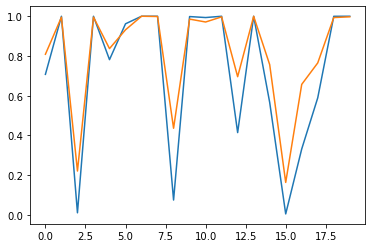

In [5]:
plt.plot(Evidence1)
plt.plot(logit(Evidence))

In [7]:
import os
import nibabel as nib
import numpy as np
from pathlib import Path
import sys
from glob import glob
from tqdm import tqdm
proj_dir = '/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/'
roi_dir = os.path.abspath(os.path.join(proj_dir,'subjects/{}_neurosketch/analysis/firstlevel/rois'))



subject_dir='/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/'
subjects=glob(subject_dir+'*_neurosketch')
subjects=[sub.split('/')[-1].split('_')[0] for sub in subjects if sub.split('/')[-1][0]!='_']
subjects_new=[]
for subject in tqdm(subjects):
    try:
        interval = 500
        for roi in ['V1', 'fusiform', 'IT', 'LOC', 'occitemp', 'parahippo']:# missing occitemp
            for run in range(1, 7):
                input_dir = f"/gpfs/milgram/scratch60/turk-browne/an633/do_not_filter_first_56s_refit_filter_parallel/{roi}"
        #         if not os.path.isdir(f"{input_dir}/{subject}"):
        #             Path(f"{input_dir}/{subject}").mkdir(parents=True, exist_ok=True)
                maskDat = nib.load('{}/{}_func_combined_{}_binarized.nii.gz'.format(roi_dir.format(subject), roi, '12')).get_fdata()
                num_voxels = np.sum(maskDat==1)
                arrays = []
                for start in range(0, num_voxels, interval):
                    try:
                        old_file_name = f"{input_dir}/{subject}/{roi}_Kalman_filter_{subject}_{run}_featurematrix_voxel_{start}_to_{start+interval}.npy"
                        dat = np.load(old_file_name)
                        arrays.append(dat)
                    except Exception as e:
                        print(e)
                concat_filtered_voxels = np.hstack(arrays)
                assert concat_filtered_voxels.shape[1] == num_voxels
#                 print(run, roi, concat_filtered_voxels.shape)
                new_file_name = f"{input_dir}/{roi}_Kalman_filter_{subject}_{run}_featurematrix.npy"
                # np.save(new_file_name, concat_filtered_voxels)
        print(subject)
        subjects_new.append(subject)
    except: 
        pass

  3%|▎         | 1/34 [00:07<03:54,  7.09s/it]

1206161


  6%|▌         | 2/34 [00:11<03:19,  6.25s/it]

[Errno 2] No such file or directory: '/gpfs/milgram/scratch60/turk-browne/an633/do_not_filter_first_56s_refit_filter_parallel/LOC/0119173/LOC_Kalman_filter_0119173_6_featurematrix_voxel_1000_to_1500.npy'


  9%|▉         | 3/34 [00:15<02:51,  5.53s/it]

[Errno 2] No such file or directory: '/gpfs/milgram/scratch60/turk-browne/an633/do_not_filter_first_56s_refit_filter_parallel/LOC/1206162/LOC_Kalman_filter_1206162_2_featurematrix_voxel_1000_to_1500.npy'


 12%|█▏        | 4/34 [00:26<03:41,  7.37s/it]

1201161


 15%|█▍        | 5/34 [00:33<03:31,  7.29s/it]

[Errno 2] No such file or directory: '/gpfs/milgram/scratch60/turk-browne/an633/do_not_filter_first_56s_refit_filter_parallel/occitemp/0115174/occitemp_Kalman_filter_0115174_4_featurematrix_voxel_10000_to_10500.npy'


 18%|█▊        | 6/34 [00:34<02:28,  5.30s/it]

[Errno 2] No such file or directory: '/gpfs/milgram/scratch60/turk-browne/an633/do_not_filter_first_56s_refit_filter_parallel/V1/1130161/V1_Kalman_filter_1130161_4_featurematrix_voxel_0_to_500.npy'


 21%|██        | 7/34 [00:44<03:03,  6.79s/it]

1206163
[Errno 2] No such file or directory: '/gpfs/milgram/scratch60/turk-browne/an633/do_not_filter_first_56s_refit_filter_parallel/occitemp/0120171/occitemp_Kalman_filter_0120171_6_featurematrix_voxel_0_to_500.npy'
[Errno 2] No such file or directory: '/gpfs/milgram/scratch60/turk-browne/an633/do_not_filter_first_56s_refit_filter_parallel/occitemp/0120171/occitemp_Kalman_filter_0120171_6_featurematrix_voxel_1000_to_1500.npy'
[Errno 2] No such file or directory: '/gpfs/milgram/scratch60/turk-browne/an633/do_not_filter_first_56s_refit_filter_parallel/occitemp/0120171/occitemp_Kalman_filter_0120171_6_featurematrix_voxel_1500_to_2000.npy'
[Errno 2] No such file or directory: '/gpfs/milgram/scratch60/turk-browne/an633/do_not_filter_first_56s_refit_filter_parallel/occitemp/0120171/occitemp_Kalman_filter_0120171_6_featurematrix_voxel_2000_to_2500.npy'
[Errno 2] No such file or directory: '/gpfs/milgram/scratch60/turk-browne/an633/do_not_filter_first_56s_refit_filter_parallel/occitemp/01201

 53%|█████▎    | 18/34 [00:52<00:54,  3.42s/it]

[Errno 2] No such file or directory: '/gpfs/milgram/scratch60/turk-browne/an633/do_not_filter_first_56s_refit_filter_parallel/V1/0111171/V1_Kalman_filter_0111171_4_featurematrix_voxel_2000_to_2500.npy'
[Errno 2] No such file or directory: '/gpfs/milgram/scratch60/turk-browne/an633/do_not_filter_first_56s_refit_filter_parallel/V1/1202161/V1_Kalman_filter_1202161_1_featurematrix_voxel_0_to_500.npy'
[Errno 2] No such file or directory: '/gpfs/milgram/scratch60/turk-browne/an633/do_not_filter_first_56s_refit_filter_parallel/V1/1202161/V1_Kalman_filter_1202161_1_featurematrix_voxel_500_to_1000.npy'
[Errno 2] No such file or directory: '/gpfs/milgram/scratch60/turk-browne/an633/do_not_filter_first_56s_refit_filter_parallel/V1/1202161/V1_Kalman_filter_1202161_1_featurematrix_voxel_1000_to_1500.npy'
[Errno 2] No such file or directory: '/gpfs/milgram/scratch60/turk-browne/an633/do_not_filter_first_56s_refit_filter_parallel/V1/1202161/V1_Kalman_filter_1202161_1_featurematrix_voxel_1500_to_2000.

 79%|███████▉  | 27/34 [00:59<00:15,  2.20s/it]

0110171
[Errno 2] No such file or directory: '/gpfs/milgram/scratch60/turk-browne/an633/do_not_filter_first_56s_refit_filter_parallel/V1/0119172/V1_Kalman_filter_0119172_1_featurematrix_voxel_0_to_500.npy'
[Errno 2] No such file or directory: '/gpfs/milgram/scratch60/turk-browne/an633/do_not_filter_first_56s_refit_filter_parallel/V1/0119172/V1_Kalman_filter_0119172_1_featurematrix_voxel_500_to_1000.npy'
[Errno 2] No such file or directory: '/gpfs/milgram/scratch60/turk-browne/an633/do_not_filter_first_56s_refit_filter_parallel/V1/0119172/V1_Kalman_filter_0119172_1_featurematrix_voxel_1000_to_1500.npy'
[Errno 2] No such file or directory: '/gpfs/milgram/scratch60/turk-browne/an633/do_not_filter_first_56s_refit_filter_parallel/V1/0119172/V1_Kalman_filter_0119172_1_featurematrix_voxel_1500_to_2000.npy'
[Errno 2] No such file or directory: '/gpfs/milgram/scratch60/turk-browne/an633/do_not_filter_first_56s_refit_filter_parallel/V1/0119172/V1_Kalman_filter_0119172_1_featurematrix_voxel_2000_

100%|██████████| 34/34 [00:59<00:00,  1.76s/it]

[Errno 2] No such file or directory: '/gpfs/milgram/scratch60/turk-browne/an633/do_not_filter_first_56s_refit_filter_parallel/V1/0112173/V1_Kalman_filter_0112173_1_featurematrix_voxel_0_to_500.npy'
[Errno 2] No such file or directory: '/gpfs/milgram/scratch60/turk-browne/an633/do_not_filter_first_56s_refit_filter_parallel/V1/0112173/V1_Kalman_filter_0112173_1_featurematrix_voxel_500_to_1000.npy'
[Errno 2] No such file or directory: '/gpfs/milgram/scratch60/turk-browne/an633/do_not_filter_first_56s_refit_filter_parallel/V1/0112173/V1_Kalman_filter_0112173_1_featurematrix_voxel_1000_to_1500.npy'
[Errno 2] No such file or directory: '/gpfs/milgram/scratch60/turk-browne/an633/do_not_filter_first_56s_refit_filter_parallel/V1/0112173/V1_Kalman_filter_0112173_1_featurematrix_voxel_1500_to_2000.npy'
[Errno 2] No such file or directory: '/gpfs/milgram/scratch60/turk-browne/an633/do_not_filter_first_56s_refit_filter_parallel/V1/0112173/V1_Kalman_filter_0112173_1_featurematrix_voxel_2000_to_2500.

In [9]:
# This code is a copy from the recog_features.py but to deal with the output filtered
# brain data using Kalman filtering generated by Alex.

'''
The "input" of this code is 
    regressor file: recog_reg 
        which looks like three colum regressors that are used in FEAT, each object (ABCD) has a seperate regressor file?
    raw brain data: 

    where is the behavior data? at what time is each image presented? That would be the regressor file
'''

import pandas as pd
import nibabel as nib
from glob import glob
import os
from subprocess import call
import sys
import numpy as np    
import time
# sys.path.append('/gpfs/milgram/scratch60/turk-browne/kp578/rtAttenPenn_cloud/rtAtten')
import ray
from pykalman import KalmanFilter
from tqdm import tqdm

ray.init(ignore_reinit_error=True)
@ray.remote(num_cpus = 0.5)
def kalman_filter_voxel(measurement):
    kf = KalmanFilter(n_dim_state = measurement.shape[1], n_dim_obs = measurement.shape[1], 
                          observation_matrices = np.eye(measurement.shape[1]),
                          observation_covariance = np.eye(measurement.shape[1]),
                          observation_offsets = np.zeros(measurement.shape[1]))
    kf = kf.em(measurement, n_iter=5,
                  em_vars = ['transition_matrices', 'transition_offsets', 'transition_covariance',
                            'observation_covariance', 'initial_state_mean', 'initial_state_covariance']
                  )
    (filtered_state_means, filtered_state_covariances) = kf.filter(measurement)
    return filtered_state_means.reshape(-1)
    
def filtering(timeseries=None, filterType='highPassRealTime'): 
    '''
    filterType can be 
        highPassRealTime 
        highPassBetweenRuns 
        UnscentedKalmanFilter_filter # documentation: https://pykalman.github.io/
        UnscentedKalmanFilter_smooth
        KalmanFilter_filter
        KalmanFilter_smooth
        noFilter
    '''
    timeseries=timeseries.astype(np.float)
    oldShape=timeseries.shape
    timeseries=timeseries.reshape(timeseries.shape[0],-1)
    if filterType == 'highPassRealTime':
        # from highpassFunc import highPassRealTime, highPassBetweenRuns
        from highpass import highpass
        def highPassRealTime(A_matrix, TR, cutoff):
            full_matrix = np.transpose(highpass(np.transpose(A_matrix), cutoff/(2*TR), True))
            return full_matrix[-1, :]

        filtered_timeseries=[]
        for currTR in range(timeseries.shape[0]):
            filtered_timeseries.append(highPassRealTime(timeseries[:(currTR+1)],1.5,56))
        filtered_timeseries = np.asarray(filtered_timeseries)
    elif filterType == 'highPassBetweenRuns':
        # from highpassFunc import highPassRealTime, highPassBetweenRuns
        from highpass import highpass
        def highPassBetweenRuns(A_matrix, TR, cutoff):
            return np.transpose(highpass(np.transpose(A_matrix), cutoff/(2*TR), False))

        filtered_timeseries = highPassBetweenRuns(timeseries,1.5,56)
    elif filterType == 'KalmanFilter_filter_analyze_voxel_by_voxel':
        filtered_timeseries=np.zeros(timeseries.shape)
        print("time series shape", timeseries.shape)
        futures = []
        for curr_voxel in range(timeseries.shape[1]):
            measurements = np.asarray(timeseries[:,curr_voxel].reshape(-1, 1)) 
            futures.append(kalman_filter_voxel.remote(measurements))
        results = ray.get(futures)
        filtered_timeseries = np.array(results).T # transpose because results are organized by [voxel, time] 
        print("filtered_timeseries=", filtered_timeseries)
    # elif filterType == 'UnscentedKalmanFilter_filter' :
    #     from pykalman import UnscentedKalmanFilter
    #     ukf = UnscentedKalmanFilter(lambda x, w: x + np.sin(w), lambda x, v: x + v, observation_covariance=0.1)
    #     filtered_timeseries=np.zeros(timeseries.shape)
    #     for curr_voxel in range(timeseries.shape[1]):
    #         (filtered_timeseries_state_means, filtered_timeseries_state_covariances) = ukf.filter(timeseries[:,curr_voxel])
    #         filtered_timeseries[:,curr_voxel] = filtered_timeseries_state_means.reshape(-1)
    # elif filterType == 'UnscentedKalmanFilter_smooth':
    #     from pykalman import UnscentedKalmanFilter
    #     ukf = UnscentedKalmanFilter(lambda x, w: x + np.sin(w), lambda x, v: x + v, observation_covariance=0.1)
    #     filtered_timeseries=np.zeros(timeseries.shape)
    #     for curr_voxel in range(timeseries.shape[1]):
    #         (smoothed_state_means, smoothed_state_covariances) = ukf.smooth(data)
    #         filtered_timeseries[:,curr_voxel] = smoothed_state_means.reshape(-1)
    # elif filterType == 'KalmanFilter_filter_analyze_all_voxels': # KALMAN FILTER ALL VOXELS NOT WORKING
    #     print('oldShape=',oldShape)
    #     kf = KalmanFilter(n_dim_state = oldShape[1], n_dim_obs = oldShape[1], 
    #                       observation_matrices = np.eye(oldShape[1]),
    #                       observation_covariance = np.eye(oldShape[1]),
    #                       observation_offsets = np.zeros(oldShape[1]))
    #     print("time series shape", timeseries.shape)
    #     kf = kf.em(timeseries, run, n_iter=5,
    #               em_vars = ['transition_matrices', 'transition_offsets', 'transition_covariance',
    #                         'observation_covariance', 'initial_state_mean', 'initial_state_covariance']
    #               )
    #     (filtered_state_means, filtered_state_covariances) = kf.filter(measurements)
    #     filtered_timeseries[:,curr_voxel] = filtered_state_means.reshape(-1)
    # elif filterType == 'KalmanFilter_filter':
    #     from pykalman import KalmanFilter
    #     kf = KalmanFilter(transition_matrices = None, observation_matrices = None)
    #     filtered_timeseries=np.zeros(timeseries.shape)
    #     for curr_voxel in range(timeseries.shape[1]):
    #         measurements = np.asarray(timeseries[:,curr_voxel]) 
    #         kf = kf.em(measurements, n_iter=5)
    #         (filtered_state_means, filtered_state_covariances) = kf.filter(measurements)
    #         filtered_timeseries[:,curr_voxel] = filtered_state_means.reshape(-1)
    # elif filterType == 'KalmanFilter_filter':
    #     from pykalman import KalmanFilter
    #     kf = KalmanFilter(n_dim_obs = timeseries.shape[1], n_dim_state = timeseries.shape[1], 
    #                           observation_matrices = sparse.eye(timeseries.shape[1]), 
    #                           observation_offsets = np.zeros(timeseries.shape[1]),
    #                           observation_covariance = sparse.eye(timeseries.shape[1]))
    #     kf = kf.em(timeseries, run, n_iter=10)
    #     (filtered_state_means, filtered_state_covariances) = kf.filter(timeseries)
    #     filtered_timeseries = filtered_state_means.reshape(-1)
    # elif filterType == 'KalmanFilter_smooth':
    #     from pykalman import KalmanFilter
    #     kf = KalmanFilter(transition_matrices = None, observation_matrices = None)
    #     filtered_timeseries=np.zeros(timeseries.shape)
    #     for curr_voxel in range(timeseries.shape[1]):
    #         measurements = np.asarray(timeseries[:,curr_voxel]) 
    #         kf = kf.em(measurements, n_iter=5)
    #         (smoothed_state_means, smoothed_state_covariances) = kf.smooth(measurements)
    #         filtered_timeseries[:,curr_voxel] = smoothed_state_means.reshape(-1)
    elif filterType == 'noFilter':
        filtered_timeseries = timeseries
    else:
        raise Exception('filterType wrong')

    filtered_timeseries=filtered_timeseries.reshape(oldShape)
    return filtered_timeseries


def recog_features(subject='0110171',filterType = 'highPassBetweenRuns',tag=''):

    os.chdir('/gpfs/milgram/scratch60/turk-browne/kp578/rtAttenPenn_cloud/rtAtten/')
    subject = subject.split('_')[0]
    proj_dir = '/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/'
    dat_type = 'recog'
    data_dir = os.path.abspath(os.path.join(proj_dir,'features')) # this is the output folder where output features are saved

    # INPUT: brain data
    feature_dir = os.path.abspath(os.path.join(data_dir, filterType)) #This is the output folder, where the output features are saved
    if not os.path.isdir(feature_dir):
        os.mkdir(feature_dir)
    filt_func = os.path.abspath(os.path.join(proj_dir, \
        'subjects/{}_neurosketch/data/nifti/realtime_preprocessed',
        '{}_neurosketch_recognition_run_{}.nii.gz')) # input, the continuous time series, brain data.
    recog_reg = os.path.abspath(os.path.join(proj_dir, \
        'subjects/{}_neurosketch/regressor/run_{}/{}.txt')) # this is regressor file

    roi_dir = os.path.abspath(os.path.join(proj_dir,'subjects/{}_neurosketch/analysis/firstlevel/rois'))

    # /gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/surfroi/0110171_neurosketch_V1.nii.gz    88*128*128
    # /gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/0110171_neurosketch/data/nifti/0110171_neurosketch_anat_mprage_brain.nii.gz.   256*256*176
    # /gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/0110171_neurosketch/analysis/firstlevel/rois/V1_func_run_1.nii.gz 94*94*72 #note V1_func_run_{1~6}.nii.gz are the same
    # /gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/0110171_neurosketch/data/nifti/0110171_neurosketch_recognition_run_1.nii.gz 94*94*72

    out_dir = os.path.abspath(os.path.join(feature_dir, 'recognition',tag)) 
    call(f"mkdir -p {out_dir}",shell=True)
    # if not os.path.isdir(out_dir):
        # os.mkdir(out_dir)

    objects = ['bed', 'bench', 'chair', 'table']
    roi_list_masks = ['V1', 'fusiform', 'IT', 'LOC', 'occitemp', 'parahippo'] #['V1', 'V2','LOC_FS','IT_FS','fusiform_FS','parahippo_FS','PRC_FS','ento_FS','hipp_FS','V1Draw', 'V2Draw', 'LOCDraw', 'ParietalDraw']
    roi_list_names = ['V1', 'fusiform', 'IT', 'LOC', 'occitemp', 'parahippo'] #['V1','V2','LOC','IT','fusiform','parahippo','PRC','ento','hipp', 'V1Draw', 'V2Draw', 'LOCDraw', 'ParietalDraw']

    for curr_phase,phase in enumerate(['12', '34', '56']):
        # initialize data columns
        subj = [subject] * 160
        label = []
        run_num = [phase[0]]*80 + [phase[1]]*80
        TR_num = []
        for roi, roiname in zip(roi_list_masks, roi_list_names):
            for rn, run in enumerate(phase): # phase is '12' or '34' or '56'
                print('creating features for run {}'.format(run))

                # load subject's time series for this run
                # timeseries = nib.load(filt_func.format(subject, subject, run))
                # timeseries = timeseries.get_data().transpose((3, 0, 1, 2))
                
                # A=time.time()
                # timeseries = filtering(timeseries=timeseries, filterType=filterType)
                # B=time.time()
                # print('timeseries.shape=',timeseries.shape)
                # print(f'filtering time passed={B-A} s for run {run} ')

                
                if tag=='':
                    timeseries = np.load(f"/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/filtered_timeSeries/{roi}/{roi}_Kalman_filter_{sub}_{run}_featurematrix.npy")
                elif tag=='condition1':
                    timeseries = np.load(f"/gpfs/milgram/scratch60/turk-browne/an633/filter_all_TRs/{roi}/{roi}_Kalman_filter_{sub}_{run}_featurematrix.npy") #condition1
                elif tag=='condition2':
                    timeseries = np.load(f"/gpfs/milgram/scratch60/turk-browne/an633/do_not_filter_first_56s/{roi}/{roi}_Kalman_filter_{sub}_{run}_featurematrix.npy")
                elif tag=='condition3':
                    timeseries = np.load(f"/gpfs/milgram/scratch60/turk-browne/an633/filter_all_TRs_refit_filter/{roi}/{roi}_Kalman_filter_{sub}_{run}_featurematrix.npy")
                elif tag=='condition4':
                    timeseries = np.load(f"/gpfs/milgram/scratch60/turk-browne/an633/do_not_filter_first_56s_refit_filter_parallel/{roi}/{roi}_Kalman_filter_{sub}_{run}_featurematrix.npy")
                                           
                # use information in regressor/run_x folder to make hasImage vector
                # associated TR is just the hasImage index, converted to a float
                Onsets = [0]*240
                for obj in objects:
                    with open(recog_reg.format(subject, run, obj)) as f:
                        times = [line.split(' ')[0] for line in f.read().split('\n')[:-1]]
                        for t in times:
                            TR = int(float(t)/1.5)
                            Onsets[TR] = obj

                # wherever hasImage, we want the features, aka only keep the features when there 
                # is an image shown
                features = [timeseries[n+3] for n, onset in enumerate(Onsets) if onset != 0] # move the timeseries by 3TRs, only keep the features when an image is shown
                labels = [label for label in Onsets if label != 0]
                FEATURES = np.array(features) if rn == 0 else np.vstack((FEATURES, np.array(features)))
                LABELS = labels if rn == 0 else LABELS + labels
            np.save('{}/{}_{}_{}_featurematrix.npy'.format(out_dir, subject, roiname, phase), FEATURES)
        
            ## metadata
            x = pd.DataFrame([subj, LABELS, run_num, TR_num]) # lists of the same length
            x = x.transpose()
            x.columns = ['subj','label','run_num', 'TR_num']
            x.to_csv('{}/metadata_{}_{}_{}.csv'.format(out_dir, subject, roiname, phase))

            # if curr_phase==0:
            #     FEATURES_oldShape=FEATURES.shape
            # else:
            #     assert np.allclose(FEATURES.shape,FEATURES_oldShape),"FEATURES shape not match"

        np.save('{}/{}_{}_featurematrix.npy'.format(out_dir, subject, phase), FEATURES)
        
#         for roi, roiname in zip(roi_list_masks, roi_list_names):
#             # mask = nib.load('{}/{}.nii.gz'.format(roi_dir.format(subject), roi))
#             # mask = nib.load('{}/{}_func_combined_{}_binarized.nii.gz'.format(roi_dir.format(subject), roi,'12')) #here the phase is fixed to '12' because I found that different phases mask are different, e.g. fslview_deprecated /gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/0110171_neurosketch/analysis/firstlevel/rois/V1_func_combined_12_binarized.nii.gz /gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/0110171_neurosketch/analysis/firstlevel/rois/V1_func_combined_34_binarized.nii.gz are not the same!
#             # maskDat = mask.get_data()
#             masked = FEATURES[:, maskDat == 1]
            

#installing rtAtten is very simple, just `conda env create -f environment.yml ; source activate rtAtten ; python setup.py install`
working_dir='/gpfs/milgram/scratch60/turk-browne/kp578/rtAttenPenn_cloud/rtAtten/' 
os.chdir(working_dir)
print('pwd=',os.getcwd())
print('CONDA_DEFAULT_ENV=',os.environ['CONDA_DEFAULT_ENV'])
subject_dir='/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/'
subjects=glob(subject_dir+'*_neurosketch')
subjects=[sub.split('/')[-1].split('_')[0] for sub in subjects if sub.split('/')[-1][0]!='_']
subjects=['1206161', '1201161', '1206163', '0110171'] #['0110171','1206161']

tag='condition4'

for sub in tqdm(subjects):
    filterType='KalmanFilter_filter_analyze_voxel_by_voxel'
    print('sub=',sub)
    print('filterType=',filterType)

    try:
        recog_features(subject=sub, filterType = filterType,tag=tag)
    except:
        pass


# This script only need to be run sepearately, doesn't need any parent script to run. e.g. in the jupyter notebok in rtAtten environment

2020-11-11 09:10:49,449	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8265
  0%|          | 0/4 [00:00<?, ?it/s]

pwd= /gpfs/milgram/scratch60/turk-browne/kp578/rtAttenPenn_cloud/rtAtten
CONDA_DEFAULT_ENV= /gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten
sub= 1206161
filterType= KalmanFilter_filter_analyze_voxel_by_voxel
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 5
creating features for run 6
creating features for run 5
creating features for run

 25%|██▌       | 1/4 [00:17<00:53, 17.76s/it]

creating features for run 5
creating features for run 6
sub= 1201161
filterType= KalmanFilter_filter_analyze_voxel_by_voxel
creating features for run 1
sub= 1206163
filterType= KalmanFilter_filter_analyze_voxel_by_voxel
creating features for run 1
sub= 0110171
filterType= KalmanFilter_filter_analyze_voxel_by_voxel
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating fea

100%|██████████| 4/4 [00:20<00:00,  5.19s/it]
